In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('movieReplicationSet-2.csv')

In [4]:
labels_columns = df.columns[:400].to_list()

In [5]:
labels= df[labels_columns]

In [6]:
names = df.columns[421:464].tolist()
names
clean_data = df.dropna(subset=names)[names]
clean_data.shape

(1000, 43)

In [7]:
personality = clean_data.iloc[:,0:]
personality.columns

Index(['Tends to find fault with others', 'Does a thorough job',
       'Is depressed/Blue', 'Is original/comes up with new ideas',
       'Is reserved', 'Is helpful and unselfish with others',
       'Can be somewhat careless', 'Is relaxed/handles stress well',
       'Is curious about many different things', 'Is full of energy',
       'Starts quarrels with others', 'Is a reliable worker', 'Can be tense',
       'Is ingenious/a deep thinker', 'Generates a lot of Enthusiasm',
       'Has a forgiving nature', 'Tends to be disorganized', 'Worries a lot',
       'Has an active imagination', 'Tends to be quiet',
       'Is generally trusting', 'Tends to be lazy',
       'Is emotionally stable/not easily upset', 'is inventive',
       'Has an assertive personality', 'Can be cold and aloof',
       'Perseveres until the task is finished', 'Can be moody',
       'Values artistic/aesthetic experiences', 'Is sometimes shy/inhibited',
       'Is considerate and kind to almost everyone', 'Does t

In [8]:
zscoredData = stats.zscore(personality)
pca = PCA().fit(zscoredData)
eigVals = pca.explained_variance_
loadings = pca.components_
rotatedData = pca.fit_transform(zscoredData)
covarExplained = eigVals/sum(eigVals)*100
for ii in range(len(covarExplained)):
    print(covarExplained[ii].round(3))

14.924
9.213
7.623
7.53
5.585
4.752
2.488
2.37
2.134
2.07
2.021
1.934
1.861
1.802
1.745
1.697
1.629
1.588
1.534
1.474
1.444
1.424
1.366
1.287
1.274
1.208
1.202
1.187
1.115
1.101
1.06
1.031
1.011
0.97
0.962
0.93
0.91
0.865
0.831
0.796
0.767
0.728
0.556


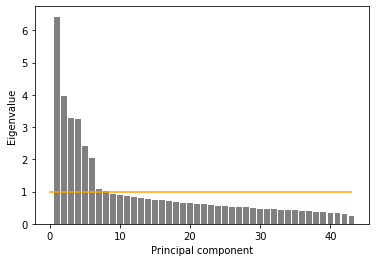

In [9]:
numClasses = 43
x = np.linspace(1,numClasses,numClasses)
plt.bar(x, eigVals, color='gray')
plt.plot([0,numClasses],[1,1],color='orange') # Orange Kaiser criterion line for the fox
plt.xlabel('Principal component')
plt.ylabel('Eigenvalue')
plt.show()

In [10]:
threshold = 1
print('Number of factors selected by Kaiser criterion:', np.count_nonzero(eigVals > threshold))

# 2) The "elbow" criterion: Pick only factors left of the biggest/sharpest
# drop. Here, this would yield 1 factor.
print('Number of factors selected by elbow criterion: 1')

# 3) Number of factors that account for 90% of the variance (Eigenvalues that 
# add up to 90% of the Eigensum. To account for at least 90% of the variability 
# in this data, we need 3 factors.
threshold = 90
eigSum = np.cumsum(covarExplained)
print('Number of factors to account for at least 90% variance:', np.count_nonzero(eigSum < threshold) + 1)

Number of factors selected by Kaiser criterion: 8
Number of factors selected by elbow criterion: 1
Number of factors to account for at least 90% variance: 32


In [11]:
pca_personality = rotatedData[:,0:8]
pca_personality.shape

(1000, 8)

In [12]:
pca_personality_names = ['PCA_P1','PCA_P2','PCA_P3','PCA_P4','PCA_P5','PCA_P6','PCA_P7','PCA_P8']

In [13]:
df_personality = pd.DataFrame(pca_personality, columns=pca_personality_names)
df_personality

,PCA_P1,PCA_P2,PCA_P3,PCA_P4,PCA_P5,PCA_P6,PCA_P7,PCA_P8
0,1.700756,1.096904,-1.467468,2.008226,1.806614,-1.166899,2.031271,-0.343101
1,0.267793,0.205632,0.567068,1.212830,-1.321864,0.054545,0.606854,0.819468
2,-1.448251,-2.867618,-0.846076,0.387358,-1.568723,2.646537,0.456053,1.095324
3,2.335236,-0.021206,1.297403,-0.396473,-1.710503,0.046412,0.885262,1.660778
4,6.253771,0.353503,-0.518327,2.059972,0.871056,1.791034,2.132546,0.157806
...,...,...,...,...,...,...,...,...
995,0.247545,-1.564720,-1.733931,-0.151614,-0.733826,0.897483,1.604219,0.283782
996,-1.400862,-2.514377,1.326243,-0.357193,0.181470,-5.655303,0.712005,1.209439
997,-2.135764,-1.561674,-3.740326,-0.088669,-0.734423,0.670786,1.227290,-1.754652
998,-0.845289,-3.561256,-0.066931,2.513183,0.419395,-1.481184,0.185207,-0.286366


In [23]:
RMSE = []
for i in range(400): 
    dataset=pd.DataFrame.merge(df_personality,labels[labels_columns[i]], left_index =True , right_index = True,how = 'inner')
    dataset.dropna(inplace= True)
    x = dataset.iloc[:,:8]
    y = dataset.iloc[:,8:]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 100)
    
    from sklearn.model_selection import RandomizedSearchCV
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)] # Number of trees in random forest
    max_features = ['auto', 'sqrt'] # Num of features to consider at every split
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] # Max number of levels in tree
    max_depth.append(None) # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10] # Min number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4] # Method of selecting samples for training each tree
    bootstrap = [True, False]
    
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    
    rf = RandomForestRegressor() 
    
    #create a cross-validation scheme
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    rf_random.fit(x_train, y_train.values.ravel()) # Fit the random search model
    best_random = rf_random.best_estimator_
    testing= best_random.predict(x_test)
    rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, testing))
    
    print('RMSE is '+str(round(rootMeanSqErr,2)))
    dataset['predicted_values'] = 0 # score on all data
    y_pred_mlr= best_random.predict(x)
    dataset['predicted_values'] = y_pred_mlr
    print(labels_columns[i])
    globals()['dataset_%s' % labels_columns[i][:-7].replace(' ','')] = dataset
    print('this is the DF dataset_%s' % labels_columns[i][:-7].replace(' ',''))
    print('_________')
    RMSE.append(rootMeanSqErr)
    
    

Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.46
The Life of David Gale (2003)
this is the DF dataset_TheLifeofDavidGale
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.04
Wing Commander (1999)
this is the DF dataset_WingCommander
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.91
Django Unchained (2012)
this is the DF dataset_DjangoUnchained
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.24
Alien (1979)
this is the DF dataset_Alien
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.97
Indiana Jones and the Last Crusade (1989)
this is the DF dataset_IndianaJonesandtheLastCrusade
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.29
Snatch (2000)
this is the DF dataset_Snatch
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.06
Rambo: First Blood Part II
this is the DF datas

RMSE is 0.93
Clueless (1995)
this is the DF dataset_Clueless
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.24
The Omen (1976)
this is the DF dataset_TheOmen
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.02
Shrek 2 (2004)
this is the DF dataset_Shrek2
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.5s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   1.9s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   0.8s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   1.6s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   2.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.5s
[CV] END bootstrap=False, max_depth=60, ma

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.1sRMSE is 0.9
Good Will Hunting (1997)
this is the DF dataset_GoodWillHunting
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.17
Just Like Heaven (2005)
this is the DF dataset_JustLikeHeaven
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.5s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   1.6s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.2s
[CV] END bootstrap=

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.3s[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.7s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   1.9s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.4s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, 

[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.5sRMSE is 1.11
Showgirls (1995)
this is the DF dataset_Showgirls
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.7s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   1.9s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   0.7s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   1.6s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, ma

[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.1sRMSE is 1.0
Diamonds are Forever (1971)
this is the DF dataset_DiamondsareForever
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.1s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.2s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.3s
[CV] END bootstrap=Fals

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   4.6sRMSE is 1.08
Crossroads (2002)
this is the DF dataset_Crossroads
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.2s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.0s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.3s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.1s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.1s
[CV] END bootstrap=True, max_depth=100, 

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.9s[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   2.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   2.1s
[CV] END bootstrap=False, max_depth=80, ma

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.5s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   1.6s
[CV] END bootstrap=False, max_depth=90, 

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   4.2sRMSE is 1.25
Pieces of April (2003)
this is the DF dataset_PiecesofApril
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   2.1s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   0.7s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   1.6s
[CV] END bootstrap=True, max_dept

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.1s[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.1s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.2s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.3s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.5s
[CV] END bootstrap=True, max_depth=100

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   4.0sRMSE is 1.24
Torque (2004)
this is the DF dataset_Torque
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   0.8s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   1.6s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.1s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.3s
[CV] END bootstrap=True, max_depth=30, max_feat

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   4.4s[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   0.8s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   2.3s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.7sRMSE is 1.18
Poltergeist (1982)
this is the DF dataset_Poltergeist
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.0s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.8s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.3s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.8s
[CV] END bootstrap=True, max_depth=10

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.9sRMSE is 1.21
Fear and Loathing in Las Vegas (1998)
this is the DF dataset_FearandLoathinginLasVegas
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.28
Barbarella (1968)
this is the DF dataset_Barbarella
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.2s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   2.3s
[CV] 

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   3.0sRMSE is 1.17
The King of Marvin Gardens (1972)
this is the DF dataset_TheKingofMarvinGardens
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.27
The Poseidon Adventure (1972)
this is the DF dataset_ThePoseidonAdventure
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.04
The Rock (1996)
this is the DF dataset_TheRock
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.2s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.5s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   3.1sRMSE is 0.82
Love Story (1970)
this is the DF dataset_LoveStory
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.96
The Last Samurai (2003)
this is the DF dataset_TheLastSamurai
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.83
The Jungle Book (1967)
this is the DF dataset_TheJungleBook
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.16
The Exorcist (1973)
this is the DF dataset_TheExorcist
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.96
Pirates of the Caribbean: Dead Man's Chest (2006)
this is the DF dataset_PiratesoftheCaribbean:DeadMan'sChest
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.99
Gone in Sixty Seconds (2000)
this is the DF dataset_GoneinSixtySeconds
_________
Fitting 3 

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.7s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.7s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.0s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   3.5s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.4s
[CV] END bootstrap=True, max_depth=50

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.4sRMSE is 1.1
Once Upon a Time in America (1984)
this is the DF dataset_OnceUponaTimeinAmerica
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.8s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.6s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.8s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.9s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   3.1s
[CV] EN

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5sRMSE is 1.16
Equilibrium (2002)
this is the DF dataset_Equilibrium
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.7s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.9s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.0s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.7s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.1s
[CV] END bootstrap=False, max_depth=8

[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.2s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.7s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   4.4s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.1s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.5s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.4s
[CV] END bootstrap=True, max_depth=50, m

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.9s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.4s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.7s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.4s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.9s
[CV] END bootstrap=False, max_dept

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.2sRMSE is 1.11
Star Wars: Episode II - Attack of the Clones (2002)
this is the DF dataset_StarWars:EpisodeII-AttackoftheClones
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.4s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.3s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.7s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   2.0s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=20

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.9s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.3s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.8s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.6s
[CV] END bootstrap=True, max_depth=50

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.1sRMSE is 1.17
The Thing (1982)
this is the DF dataset_TheThing
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, max_fe

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.6s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.5s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.1s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   4.5s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   4.2s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.2s
[CV] END bootstrap=True, max_depth=

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   4.8sRMSE is 0.77
Interstellar (2014)
this is the DF dataset_Interstellar
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.06
Full Metal Jacket (1987)
this is the DF dataset_FullMetalJacket
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   4.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.7s
[CV] END bootstrap=False

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.3s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.4s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.4s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   4.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.7s
[CV] END bootstrap=False, max_depth=

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4sRMSE is 1.22
Big Fish (2003)
this is the DF dataset_BigFish
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   3.0s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.7s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.5s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, max_

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.0sRMSE is 1.28
Cool Hand Luke (1967)
this is the DF dataset_CoolHandLuke
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.1s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   4.6s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.4s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.3s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.1s
[CV] END bootstrap=True, max_

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4sRMSE is 0.86
A Beautiful Mind (2001)
this is the DF dataset_ABeautifulMind
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.2
Sholay (1978)
this is the DF dataset_Sholay
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.3s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.2s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.4s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.5s
[CV] END bootstrap=False, max_depth=60, m

[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.0sRMSE is 1.18
The 51st State (2001)
this is the DF dataset_The51stState
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.5s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=True, max_depth

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6sRMSE is 1.15
Die Hard With a Vengeance (1995)
this is the DF dataset_DieHardWithaVengeance
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.06
Elf (2003)
this is the DF dataset_Elf
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.17
The Blue Lagoon (1980)
this is the DF dataset_TheBlueLagoon
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.22
Hellraiser (1987)
this is the DF dataset_Hellraiser
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.06
Moonraker (1979)
this is the DF dataset_Moonraker
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.51
Leon (1994)
this is the DF dataset_Leon
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.18
Mystic River (2003)
this is 

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4sRMSE is 1.16
Carrie (1976)
this is the DF dataset_Carrie
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.8s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.0s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.2s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.6s
[CV] END bootstrap=False, max_depth=80, max_fea

[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.0s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.7s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.8s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.5s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   0.9s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.0s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.3s
[CV] END bootstrap=True, max_depth=5

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   3.0sRMSE is 1.06
The Good the Bad and the Ugly (1966)
this is the DF dataset_TheGoodtheBadandtheUgly
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.08
Speed 2: Cruise Control (1997)
this is the DF dataset_Speed2:CruiseControl
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.6s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.6s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; tota

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.7s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   2.9s
[CV] END bootstrap=False, max_depth=60, 

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   2.8s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.9s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.7s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=5

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.0sRMSE is 0.99
The Lord of the Rings: The Fellowship of the Ring (2001)
this is the DF dataset_TheLordoftheRings:TheFellowshipoftheRing
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.0s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estim

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   3.1sRMSE is 1.03
The Talented Mr. Ripley (1999)
this is the DF dataset_TheTalentedMr.Ripley
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.3s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.1s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.2s
[CV] END bootst

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.3sRMSE is 1.27
Casino (1995)
this is the DF dataset_Casino
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.8s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.6s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, max_feat

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4sRMSE is 1.05
A Time to Kill (1996)
this is the DF dataset_ATimetoKill
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.7s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.1s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.0s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.2s
[CV] END bootstrap=True, max_dept

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.2sRMSE is 1.2
Blazing Saddles (1974)
this is the DF dataset_BlazingSaddles
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.3
The Doom Generation (1995)
this is the DF dataset_TheDoomGeneration
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.1s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.0s
[CV] END bootstrap

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.4sRMSE is 1.02
Armageddon (1998)
this is the DF dataset_Armageddon
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.84
X-Men (2000)
this is the DF dataset_X-Men
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.5s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.2s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.2s
[CV] END bootstrap=False, max_depth=80, max_featu

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5sRMSE is 1.22
Arachnophobia (1990)
this is the DF dataset_Arachnophobia
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.19
Stir Crazy (1980)
this is the DF dataset_StirCrazy
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.8s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.9s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.5s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.6s
[CV] END bootstrap=False, max_dept

[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.1sRMSE is 1.43
Billy Jack (1971)
this is the DF dataset_BillyJack
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.3s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.4s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   2.8s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, m

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4sRMSE is 1.25
The Silencers (1966)
this is the DF dataset_TheSilencers
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.13
The Three Musketeers (1993)
this is the DF dataset_TheThreeMusketeers
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.96
Girl Interrupted (1999)
this is the DF dataset_GirlInterrupted
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.2s
[CV] END

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.8sRMSE is 0.79
Finding Nemo (2003)
this is the DF dataset_FindingNemo
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.32
Tropic of Cancer (1970)
this is the DF dataset_TropicofCancer
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.83
The Sixth Sense (1999)
this is the DF dataset_TheSixthSense
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.11
I Know What You Did Last Summer (1997)
this is the DF dataset_IKnowWhatYouDidLastSummer
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.03
Indiana Jones and the Kingdom of the Crystal Skull (2008)
this is the DF dataset_IndianaJonesandtheKingdomoftheCrystalSkull
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.24
Divine Secrets of the Ya-Ya Sisterhood (20

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.5sRMSE is 1.34
Rosemary's Baby (1968)
this is the DF dataset_Rosemary'sBaby
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.3s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   5.7s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.3s
[CV] END bootstrap=False, max_

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   3.5sRMSE is 1.12
Cheaper by the Dozen (2003)
this is the DF dataset_CheaperbytheDozen
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.7s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.4s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   2.0s
[CV] END bootstrap=Tru

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.4s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   3.3s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.0s
[CV] END bootstrap=False, max_depth=60, 

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   6.0s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.7s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.4s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.8s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.2s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.3s
[CV] END bootstrap=False, max_depth=6

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.0s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.1s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.4s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   3.1s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.2s
[CV] END bootstrap=True, max_depth=50

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.6sRMSE is 1.21
Can't Hardly Wait (1998)
this is the DF dataset_Can'tHardlyWait
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.2
Die Another Day (2002)
this is the DF dataset_DieAnotherDay
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.2s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   2.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.7s
[CV] END bootstrap=Tru

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.5s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.1s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   4.5s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.7s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.6s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=5

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.5sRMSE is 0.83
Toy Story 2 (1999)
this is the DF dataset_ToyStory2
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.21
Transformers: Age of Extinction (2014)
this is the DF dataset_Transformers:AgeofExtinction
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.24
Like Stars on Earth (2007)
this is the DF dataset_LikeStarsonEarth
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.15
Terminator 2: Judgement Day (1991)
this is the DF dataset_Terminator2:JudgementDay
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.7sRMSE is 1.11
25th Hour (2002)
this is the DF dataset_25thHour
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.1
Who's Afraid of Virginia Woolf (1966)
this is the DF dataset_Who'sAfraidofVirginiaWoolf
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.23
Adaption (2002)
this is the DF dataset_Adaption
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.7s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.9s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END boo

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.0sRMSE is 0.99
Life is Beautiful (1997)
this is the DF dataset_LifeisBeautiful
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   3.3s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.7s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.1s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.1s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.7s
[CV] END bootstrap=Fal

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.9sRMSE is 1.07
Room (2015)
this is the DF dataset_Room
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.3s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   4.9s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, max_features

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.5sRMSE is 1.13
Scream (1996)
this is the DF dataset_Scream
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.3
The Evil Dead (1981)
this is the DF dataset_TheEvilDead
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.21
Gangs of New York (2002)
this is the DF dataset_GangsofNewYork
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.21
Stand By Me (1986)
this is the DF dataset_StandByMe
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.9s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.1s
[CV] END bootstrap=True, max_depth=

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.4sRMSE is 1.06
The Vow (2012)
this is the DF dataset_TheVow
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.8s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   4.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.2s
[CV] END bootstrap=True, max_depth=10, max_f

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4sRMSE is 0.85
Toy Story 3 (2010)
this is the DF dataset_ToyStory3
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.13
The Matrix Reloaded (2003)
this is the DF dataset_TheMatrixReloaded
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.25
Once Upon a Time in the West (1968)
this is the DF dataset_OnceUponaTimeintheWest
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.0
Star Wars: Episode V - The Empire Strikes Back (1980)
this is the DF dataset_StarWars:EpisodeV-TheEmpireStrikesBack
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.03
War Games (1983)
this is the DF dataset_WarGames
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.02
Kill Bill: Vol. 2 (2004)
this is the DF dataset_KillBill:Vol.2
___

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4sRMSE is 1.24
Happy Gilmore (1996)
this is the DF dataset_HappyGilmore
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.14
My Big Fat Greek Wedding (2002)
this is the DF dataset_MyBigFatGreekWedding
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.8s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.8s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END boo

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   2.9sRMSE is 1.35
Boomerang (1992)
this is the DF dataset_Boomerang
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.5s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, max_f

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.1sRMSE is 0.96
The Avengers (2012)
this is the DF dataset_TheAvengers
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.2s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.7s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.5s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.7s
[CV] END bootstrap=False, max_depth

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.7s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   5.2s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.2s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.5s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.2s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.5s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.1s
[CV] END bootstrap=False, max_depth=

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6sRMSE is 1.3
In America (2002)
this is the DF dataset_InAmerica
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.2s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.7s
[CV] END bootstrap=True, max_depth=50, max_

[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   3.3sRMSE is 0.88
Tarzan (1999)
this is the DF dataset_Tarzan
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.8s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.8s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.4s
[CV] END bootstrap=True, max_depth=50, max_featu

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   8.8s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.7s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.6s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   4.0s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, max_depth=50

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.1sRMSE is 1.48
Scent of a Woman (1992)
this is the DF dataset_ScentofaWoman
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.2
The Cabin in the Woods (2012)
this is the DF dataset_TheCabinintheWoods
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.89
Spider-Man (2002)
this is the DF dataset_Spider-Man
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.06
Broken Arrow (1996)
this is the DF dataset_BrokenArrow
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.7s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.9s
[CV] END boo

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.9sRMSE is 1.41
Baby Geniuses (1999)
this is the DF dataset_BabyGeniuses
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.25
Battlefield Earth (2000)
this is the DF dataset_BattlefieldEarth
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.3
The Firm (1993)
this is the DF dataset_TheFirm
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   3.2s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, ma

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.0sRMSE is 1.05
De-Lovely (2004)
this is the DF dataset_De-Lovely
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.03
Die Hard (1988)
this is the DF dataset_DieHard
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, max_feat

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4sRMSE is 1.05
The Lord of the Rings: The Two Towers (2002)
this is the DF dataset_TheLordoftheRings:TheTwoTowers
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.04
The Blair Witch Project (1999)
this is the DF dataset_TheBlairWitchProject
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  10.0s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimator

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   4.1sRMSE is 1.1
Judge Dredd (1995)
this is the DF dataset_JudgeDredd
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.7s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.1s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.0s
[CV] END bootstrap=False, max_depth=6

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.5sRMSE is 0.83
10 Things I Hate About You (1999)
this is the DF dataset_10ThingsIHateAboutYou
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.98
The Insider (1999)
this is the DF dataset_TheInsider
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.3
Erik the Viking (1989)
this is the DF dataset_EriktheViking
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.97
Pirates of the Caribbean: At World's End (2007)
this is the DF dataset_PiratesoftheCaribbean:AtWorld'sEnd
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.13
The Ring (2002)
this is the DF dataset_TheRing
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.03
The Truman Show (1998)
this is the DF dataset_TheTrumanShow
_________
Fitting 3 folds 

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.6sRMSE is 0.8
Forrest Gump (1994)
this is the DF dataset_ForrestGump
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.26
I.Q. (1994)
this is the DF dataset_I.Q.
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.05
Goodfellas (1990)
this is the DF dataset_Goodfellas
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.11
Uptown Girls (2003)
this is the DF dataset_UptownGirls
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.82
Beauty and the Beauty (1991)
this is the DF dataset_BeautyandtheBeauty
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_dept

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.4sRMSE is 0.96
Black Hawk Down (2001)
this is the DF dataset_BlackHawkDown
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.08
Knight and Day (2010)
this is the DF dataset_KnightandDay
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.96
The Shawshank Redemption (1994)
this is the DF dataset_TheShawshankRedemption
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.7s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.9s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   5.5s

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   1.1sRMSE is 1.07
Sleepy Hollow (1999)
this is the DF dataset_SleepyHollow
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.8s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   6.1s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.8s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   4.0s
[CV] END bootstrap=False, max_dep

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.9sRMSE is 0.98
The Holiday (2006)
this is the DF dataset_TheHoliday
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.4s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   4.9s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.8s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50,

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4sRMSE is 0.99
Sixteen Candles (1984)
this is the DF dataset_SixteenCandles
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.07
10000 BC (2008)
this is the DF dataset_10000BC
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.8s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   0.9s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.0s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.3s
[CV] END bootstrap=False, max_dept

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4sRMSE is 1.07
Austin Powers: The Spy Who Shagged Me (1999)
this is the DF dataset_AustinPowers:TheSpyWhoShaggedMe
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.7s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   4.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=

[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.0sRMSE is 0.77
The Lion King (1994)
this is the DF dataset_TheLionKing
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.7s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   4.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.1s
[CV] END bootstrap=False, max_depth=

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   6.7s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.9s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.6s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.9s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.9s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   4.1s
[CV] END bootstrap=False, max_depth

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4sRMSE is 1.13
Child's Play (1988)
this is the DF dataset_Child'sPlay
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.1
Anger Management (2002)
this is the DF dataset_AngerManagement
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.25
Angels in the Outfield (1994)
this is the DF dataset_AngelsintheOutfield
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   6.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   3.1s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   0.9s
[CV] END

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.5sRMSE is 1.16
Wild Wild West (1999)
this is the DF dataset_WildWildWest
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.16
Split (2016)
this is the DF dataset_Split
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.6s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.7s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.6s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.7s
[CV] END bootstrap=False, max_depth=50, max

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.9s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.1s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, max_depth=50, 

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5sRMSE is 1.04
Bad Boys (1995)
this is the DF dataset_BadBoys
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.99
The Prestige (2006)
this is the DF dataset_ThePrestige
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.39
American Graffiti (1973)
this is the DF dataset_AmericanGraffiti
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.8s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.1s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.2s
[CV] END bootstrap=True, max_de

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   4.4sRMSE is 1.03
Air Force One (1997)
this is the DF dataset_AirForceOne
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   3.7s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.0s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.6s
[CV] END bootstrap=False, max_depth

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4sRMSE is 0.86
Harry Potter and the Sorcerer's Stone (2001)
this is the DF dataset_HarryPotterandtheSorcerer'sStone
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.14
Close Encounters of the Third Kind (1977)
this is the DF dataset_CloseEncountersoftheThirdKind
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.85
Hollow Man (2000)
this is the DF dataset_HollowMan
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.03
Point Break (1991)
this is the DF dataset_PointBreak
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.88
I Robot (2004)
this is the DF dataset_IRobot
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4sRMSE is 0.88
The Dark Knight (2008)
this is the DF dataset_TheDarkKnight
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.02
Ghost (1990)
this is the DF dataset_Ghost
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.09
A Bug's Life (1998)
this is the DF dataset_ABug'sLife
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.21
American Pie (1999)
this is the DF dataset_AmericanPie
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.7s
[CV] END bootstrap=True, max_depth=100, m

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5sRMSE is 1.04
Daredevil (2003)
this is the DF dataset_Daredevil
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.01
The Bandit (1996)
this is the DF dataset_TheBandit
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.02
Grease (1978)
this is the DF dataset_Grease
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.14
The Girl Next Door (2004)
this is the DF dataset_TheGirlNextDoor
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.89
The Godfather (1972)
this is the DF dataset_TheGodfather
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, m

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.0s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   3.8s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.6s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   2.8s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   5.2s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50,

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4sRMSE is 1.22
Cloverfield (2008)
this is the DF dataset_Cloverfield
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.8s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.8s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.9s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.5s
[CV] END bootstrap=False, max_depth=

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.3sRMSE is 0.88
Rush Hour 2 (2001)
this is the DF dataset_RushHour2
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.01
Bruce Almighty (2003)
this is the DF dataset_BruceAlmighty
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.05
Girl With a Pearl Earring (2003)
this is the DF dataset_GirlWithaPearlEarring
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.24
Grown Ups 2 (2013)
this is the DF dataset_GrownUps2
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.7s
[CV] END b

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4sRMSE is 1.6
Best Laid Plans (1999)
this is the DF dataset_BestLaidPlans
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.07
Bram Stoker's Dracula (1992)
this is the DF dataset_BramStoker'sDracula
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.1s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   1.1s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   6.3s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.0s
[CV] END boots

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   5.4sRMSE is 1.27
Fahrenheit 9/11 (2004)
this is the DF dataset_Fahrenheit9/11
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.2s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.7s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.6s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.0s
[CV] END bootstrap=True, max_

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.7sRMSE is 1.14
Donnie Darko (2001)
this is the DF dataset_DonnieDarko
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.2s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   3.1s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.0s
[CV] END bootstrap=False, max_dept

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.7sRMSE is 1.19
Bad Teacher (2011)
this is the DF dataset_BadTeacher
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, 

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4sRMSE is 1.12
Cable Guy (1996)
this is the DF dataset_CableGuy
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.95
Ice Age (2002)
this is the DF dataset_IceAge
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.1s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.0s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.9s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   3.4s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   0.9s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.0s
[CV] END bootstrap=False, max_depth=8

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5sRMSE is 0.92
Misery (1990)
this is the DF dataset_Misery
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.05
8 Mile (2002)
this is the DF dataset_8Mile
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   2.8s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.8s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, m

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   4.0s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.6s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   2.9s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   6.6s
[CV] END bootstrap=True, max_depth=30

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.6sRMSE is 0.86
Harry Potter and the Deathly Hallows: Part 2 (2011)
this is the DF dataset_HarryPotterandtheDeathlyHallows:Part2
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.24
Ouija: Origin of Evil (2016)
this is the DF dataset_Ouija:OriginofEvil
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   1.0s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   3.6s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.6s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.0s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   4.4s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.6s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.7s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.3s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.9s
[CV] END bootstrap=False, max_dept

[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.2sRMSE is 0.78
Monsters  Inc.(2001)
this is the DF dataset_MonstersInc
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.51
Thoroughly Modern Millie (1967)
this is the DF dataset_ThoroughlyModernMillie
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.18
Requiem for a Dream (2000)
this is the DF dataset_RequiemforaDream
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.24
Downfall (2004)
this is the DF dataset_Downfall
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.26
L.A. Confidential (1997)
this is the DF dataset_L.A.Confidential
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.6sRMSE is 0.97
Chicago (2002)
this is the DF dataset_Chicago
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.08
Star Wars: Episode 1 - The Phantom Menace (1999)
this is the DF dataset_StarWars:Episode1-ThePhantomMenace
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.07
Rain Man (1988)
this is the DF dataset_RainMan
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.39
What Lies Beneath (2000)
this is the DF dataset_WhatLiesBeneath
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.86
Toy Story (1995)
this is the DF dataset_ToyStory
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=

[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.6sRMSE is 1.29
Boy's Don't Cry (1999)
this is the DF dataset_Boy'sDon'tCry
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.09
Pearl Harbor (2001)
this is the DF dataset_PearlHarbor
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.1s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.2s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.1s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.1s
[CV] END bootstrap=True, max_dep

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.9sRMSE is 1.23
A.I. Artificial Intelligence (2001)
this is the DF dataset_A.I.ArtificialIntelligence
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.2
The Sting (1973)
this is the DF dataset_TheSting
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.7s
[CV] END b

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.2sRMSE is 1.1
Scream 3 (2000)
this is the DF dataset_Scream3
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.38
Congo (1995)
this is the DF dataset_Congo
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.5s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   3.3s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   6.0s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.9s
[CV] END bootstrap=False, max_depth=50, max_features=auto

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.0s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.0s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=50,

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.5sRMSE is 1.21
Bowling For Columbine (2002)
this is the DF dataset_BowlingForColumbine
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   4.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.9s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.1s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   5.5s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.8s
[CV] END bootstr

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6sRMSE is 1.01
What Women Want (2000)
this is the DF dataset_WhatWomenWant
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.0
Home Alone (1990)
this is the DF dataset_HomeAlone
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.0
How the Grinch Stole Christmas (2000)
this is the DF dataset_HowtheGrinchStoleChristmas
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.3s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.3s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.9s

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.4s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.7s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.8s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   3.1s
[CV] END bootstrap=True, max_depth=30

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.6s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.0s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.1s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   4.2s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.9s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   7.2s
[CV] END bootstrap=False, max_dept

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.2s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.5s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.4s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.0s
[CV] END bootstrap=False, max_depth=8

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.4s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   3.2s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.7s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=6

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   4.5sRMSE is 1.49
Gigli (2002)
this is the DF dataset_Gigli
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.2s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.2s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.3s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.7s
[CV] END bootstrap=False, max_depth=80, max_feat

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.0s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.6s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.8s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.1s
[CV] END bootstrap=False, max_depth=80,

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6sRMSE is 1.19
Rocky V (1991)
this is the DF dataset_RockyV
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.14
The Visit (2015)
this is the DF dataset_TheVisit
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.94
Titanic (1997)
this is the DF dataset_Titanic
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.09
A Clockwork Orange (1971)
this is the DF dataset_AClockworkOrange
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.99
Charlie's Angels (2000)
this is the DF dataset_Charlie'sAngels
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.28
Friday the 13th Part III (1982)
this is the DF dataset_Fridaythe13thPartIII
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.12
H

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.9sRMSE is 1.06
Blow (2001)
this is the DF dataset_Blow
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.37
Ran (1985)
this is the DF dataset_Ran
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.0s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.5s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samp

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   7.4sRMSE is 1.28
Mulholland Dr. (2001)
this is the DF dataset_MulhollandDr.
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.0
Apocalypse Now (1979)
this is the DF dataset_ApocalypseNow
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.12
Cinema Paradiso (1988)
this is the DF dataset_CinemaParadiso
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.12
Double Jeopardy (1999)
this is the DF dataset_DoubleJeopardy
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.11
The Big Lebowski (1998)
this is the DF dataset_TheBigLebowski
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.92
The Matrix (1999)
this is the DF dataset_TheMatrix
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6sRMSE is 1.17
Memento (2000)
this is the DF dataset_Memento
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.8s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.7s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=50, max_fe

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4sRMSE is 1.04
Dogville (2003)
this is the DF dataset_Dogville
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.02
American Psycho (2000)
this is the DF dataset_AmericanPsycho
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   4.5s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.2s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.0s
[CV] END bootstrap=True, max_depth=10

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.7sRMSE is 0.87
Kill Bill: Vol. 1 (2003)
this is the DF dataset_KillBill:Vol.1
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.0s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.6s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6sRMSE is 1.12
The Fugitive (1993)
this is the DF dataset_TheFugitive
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.6s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.6sRMSE is 0.94
Bend it Like Beckham (2002)
this is the DF dataset_BenditLikeBeckham
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.23
Austin Powers in Goldmember (2002)
this is the DF dataset_AustinPowersinGoldmember
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.5sRMSE is 1.09
The Mummy Returns (2001)
this is the DF dataset_TheMummyReturns
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   2.9s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   2.7s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   5.5s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.6sRMSE is 0.94
The Nightmare Before Christmas (1993)
this is the DF dataset_TheNightmareBeforeChristmas
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.7s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.6s
[CV

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   0.9s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.0s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   4.6s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   2.9s
[CV] END bootstrap=True, max_depth=30,

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   1.1s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.8s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.8s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.3s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.1s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.1s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.6s
[CV] END bootstrap=True, max_depth=5

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   4.1sRMSE is 1.15
La La Land (2016)
this is the DF dataset_LaLaLand
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.6s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.5s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=100, max

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.4sRMSE is 1.23
Flowers in the Attic (1987)
this is the DF dataset_FlowersintheAttic
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   5.8s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.1s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True,

[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.3sRMSE is 1.09
28 Days Later (2002)
this is the DF dataset_28DaysLater
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.08
The Princess Bride (1987)
this is the DF dataset_ThePrincessBride
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.0s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False,

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.9sRMSE is 1.05
The Green Mile (1999)
this is the DF dataset_TheGreenMile
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.05
Predator (1987)
this is the DF dataset_Predator
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.0s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.7s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.5s
[CV] END bootstrap=False, max_dept

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.7sRMSE is 1.23
A Night at the Roxbury (1998)
this is the DF dataset_ANightattheRoxbury
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.26
Ed Wood (1994)
this is the DF dataset_EdWood
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.28
Aliens (1986)
this is the DF dataset_Aliens
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.1s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.7s
[CV] END bootstrap=True, max_depth=50, 

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.4sRMSE is 1.12
Meet the Parents (2000)
this is the DF dataset_MeettheParents
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.99
Independence Day (1996)
this is the DF dataset_IndependenceDay
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.13
Who Framed Roger Rabbit (1988)
this is the DF dataset_WhoFramedRogerRabbit
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.2
As Good as it Gets (1997)
this is the DF dataset_AsGoodasitGets
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.24
Butch Cassidy and the Sundance Kid (1969)
this is the DF dataset_ButchCassidyandtheSundanceKid
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4sRMSE is 1.46
You're Next (2011)
this is the DF dataset_You'reNext
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.13
The Final Conflict (1981)
this is the DF dataset_TheFinalConflict
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.19
City of God (2002)
this is the DF dataset_CityofGod
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.92
Star Wars: Episode VII - The Force Awakens (2015)
this is the DF dataset_StarWars:EpisodeVII-TheForceAwakens
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.95
The Transporter (2002)
this is the DF dataset_TheTransporter
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.91
Cast Away (2000)
this is the DF dataset_CastAway
_________
Fitting 3 folds for each of 10 c

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4sRMSE is 1.36
Saw (2004)
this is the DF dataset_Saw
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.03
Star Wars: Episode VI - The Return of the Jedi (1983)
this is the DF dataset_StarWars:EpisodeVI-TheReturnoftheJedi
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.7s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   0.9s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   1.9s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total tim

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.5s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   2.8s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50,

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.8sRMSE is 1.07
Scry Movie (2000)
this is the DF dataset_ScryMovie
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.01
E.T. The Extra-Terrestrial (1982)
this is the DF dataset_E.T.TheExtra-Terrestrial
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.25
American History X (1998)
this is the DF dataset_AmericanHistoryX
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.9s
[

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.7sRMSE is 1.21
FeardotCom (2002)
this is the DF dataset_FeardotCom
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.18
Halloween (1978)
this is the DF dataset_Halloween
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.37
Along Came a Spider (2002)
this is the DF dataset_AlongCameaSpider
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.0s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.0s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   4.1s
[CV] END bootstrap=False, ma

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   5.5s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.3s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   3.1s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.0s
[CV] END bootstrap=False, max_depth=

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   3.1sRMSE is 1.12
The Mist (2007)
this is the DF dataset_TheMist
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.0s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.5s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.9s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   7.5s
[CV] END bootstrap=False, max_depth=90, max

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.3s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.4s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.9s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   1.0s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   4.2s
[CV] END bootstrap=False, max_depth=

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.1sRMSE is 0.81
Aladdin (1992)
this is the DF dataset_Aladdin
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.96
Pirates of the Caribbean: The Curse of the Black Pearl (2003)
this is the DF dataset_PiratesoftheCaribbean:TheCurseoftheBlackPearl
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.84
Men in Black (1997)
this is the DF dataset_MeninBlack
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.7s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   2.2s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_esti

[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.2s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.7s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.8s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   1.1s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   3.7s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.7s
[CV] END bootstrap=False, max_depth=80

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4sRMSE is 1.15
Eternal Sunshine of the Spotless Mind (2004)
this is the DF dataset_EternalSunshineoftheSpotlessMind
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.05
Ocean's Eleven (2001)
this is the DF dataset_Ocean'sEleven
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.7s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.4s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; tota

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.9s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.0s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.8s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.2s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   3.3s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   5.8s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.1s
[CV] END bootstrap=False, max_dept

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.2sRMSE is 0.95
Men in Black II (2002)
this is the DF dataset_MeninBlackII
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.97
Cocktail (1988)
this is the DF dataset_Cocktail
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.91
The Wolf of Wall Street (2013)
this is the DF dataset_TheWolfofWallStreet
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.12
The Game (1997)
this is the DF dataset_TheGame
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=Fals

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.7sRMSE is 1.48
Red Sonja (1985)
this is the DF dataset_RedSonja
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.73
One Flew Over the Cuckoo's Nest (1975)
this is the DF dataset_OneFlewOvertheCuckoo'sNest
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   2.7s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.6s
[CV] EN

[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.9sRMSE is 1.25
Freddy Got Fingered (2001)
this is the DF dataset_FreddyGotFingered
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.99
The Village (2004)
this is the DF dataset_TheVillage
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.2
Miller's Crossing (1990)
this is the DF dataset_Miller'sCrossing
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.97
My Best Friend's Wedding (1997)
this is the DF dataset_MyBestFriend'sWedding
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.0
Iron Man 3 (2013)
this is the DF dataset_IronMan3
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.7sRMSE is 1.12
Big Daddy (1999)
this is the DF dataset_BigDaddy
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.85
Suspiria (1977)
this is the DF dataset_Suspiria
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.05
The Passenger (1975)
this is the DF dataset_ThePassenger
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.25
The Station Agent (2003)
this is the DF dataset_TheStationAgent
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.93
Jurassic Park (1993)
this is the DF dataset_JurassicPark
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.97
Captain America: Civil War (2016)
this is the DF dataset_CaptainAmerica:CivilWar
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMS

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.7sRMSE is 1.09
Analyze That (2002)
this is the DF dataset_AnalyzeThat
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.2
Braveheart (1995)
this is the DF dataset_Braveheart
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.6s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.8s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   0.9s
[CV] END bootstrap=True, max_depth=100, 

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.0sRMSE is 0.74
Inception (2010)
this is the DF dataset_Inception
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.6s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.6s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, ma

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.5sRMSE is 1.01
Groundhog Day (1993)
this is the DF dataset_GroundhogDay
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.3
The Lookout (2007)
this is the DF dataset_TheLookout
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.3s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.2s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.7s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.7s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.3s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.2s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.8s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.7s
[CV] END bootstrap=True, max_depth=50

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.5sRMSE is 0.62
21 Grams (2003)
this is the DF dataset_21Grams
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.04
Gladiator (2000)
this is the DF dataset_Gladiator
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.8s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.1s
[CV] END bootstrap=False, max_depth=60, max_fea

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4sRMSE is 1.34
Midnight Cowboy (1969)
this is the DF dataset_MidnightCowboy
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   5.7s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.9s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.7s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.9s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   3.2s
[CV] END bootstrap=False, max

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.5sRMSE is 1.08
Fatal Attraction (1987)
this is the DF dataset_FatalAttraction
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   3.5s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.7s
[CV] END bootstrap=True, max_

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.2s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.9s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   3.3s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.2s
[CV] END bootstrap=True, max_depth=100

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   6.2sRMSE is 1.14
House of Sand and Fog (2003)
this is the DF dataset_HouseofSandandFog
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.12
On Golden Pond (1981)
this is the DF dataset_OnGoldenPond
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.2s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.3s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.7s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.5s
[CV] END bootst

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   4.2sRMSE is 1.06
The Mummy (1999)
this is the DF dataset_TheMummy
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.0s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   2.0s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   4.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.7s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.2s
[CV] END bootstrap=False, max_depth=60, ma

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   4.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.9s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   3.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.0s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, max_depth=60

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6sRMSE is 1.14
The Descent (2005)
this is the DF dataset_TheDescent
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.05
Runaway Bride (1999)
this is the DF dataset_RunawayBride
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.3s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   4.9s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.2s
[CV] END bootstrap=True, max_depth

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   4.2sRMSE is 0.9
Harry Potter and the Goblet of Fire (2005)
this is the DF dataset_HarryPotterandtheGobletofFire
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.27
Gods and Generals (2003)
this is the DF dataset_GodsandGenerals
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.09
My Father and My Son (2005)
this is the DF dataset_MyFatherandMySon
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.93
X-Men 2 (2003)
this is the DF dataset_X-Men2
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.15
The Usual Suspects (1995)
this is the DF dataset_TheUsualSuspects
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4sRMSE is 1.12
The Mask (1994)
this is the DF dataset_TheMask
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.98
Jaws (1975)
this is the DF dataset_Jaws
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 0.91
Harry Potter and the Chamber of Secrets (2002)
this is the DF dataset_HarryPotterandtheChamberofSecrets
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.23
Patton (1970)
this is the DF dataset_Patton
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=T

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.0sRMSE is 1.14
Anaconda (1997)
this is the DF dataset_Anaconda
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   4.1s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.6s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.9s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.3s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.6s
[CV] END bootstrap=True, max_depth=30,

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4sRMSE is 1.13
Twister (1996)
this is the DF dataset_Twister
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.24
MacArthur (1977)
this is the DF dataset_MacArthur
_________
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE is 1.12
Look Who's Talking (1989)
this is the DF dataset_LookWho'sTalking
_________


In [33]:
dataset_Twister

,PCA_P1,PCA_P2,PCA_P3,PCA_P4,PCA_P5,PCA_P6,PCA_P7,PCA_P8,Twister (1996),predicted_values
4,6.253771,0.353503,-0.518327,2.059972,0.871056,1.791034,2.132546,0.157806,1.5,2.048361
7,0.123942,-2.189255,0.379305,-2.907284,-1.315614,-1.764368,0.040184,-0.809914,4.0,2.467250
22,-4.329185,-0.599086,1.227636,2.642176,2.528909,1.091779,-0.990390,-0.423575,3.5,2.416977
25,1.905694,0.248135,1.568738,-0.075355,0.339449,0.484761,-1.004486,-0.935276,1.5,2.620174
62,0.284381,-0.209941,0.548449,1.043232,-0.878793,1.417062,0.335232,-0.107563,1.5,2.410496
...,...,...,...,...,...,...,...,...,...,...
979,1.408318,-1.455453,-0.907384,-0.385319,-1.285507,-2.626450,0.673905,1.880744,3.5,2.316942
982,0.978887,-1.056334,-0.356477,0.608149,1.117760,0.869153,-0.416621,1.028199,2.0,2.466340
985,-4.577770,3.322085,-0.072749,-0.346635,0.006589,-0.107496,-1.326335,-0.189791,1.5,2.663076
993,8.279633,-0.242119,0.875112,0.167484,0.108786,-0.987202,-0.258391,-0.305779,2.5,2.495304


In [31]:
dataset.iloc[:,:8]

,PCA_P1,PCA_P2,PCA_P3,PCA_P4,PCA_P5,PCA_P6,PCA_P7,PCA_P8
7,0.123942,-2.189255,0.379305,-2.907284,-1.315614,-1.764368,0.040184,-0.809914
11,0.655259,1.095755,2.778771,1.363950,0.438967,-0.816387,0.030107,-1.135875
22,-4.329185,-0.599086,1.227636,2.642176,2.528909,1.091779,-0.990390,-0.423575
25,1.905694,0.248135,1.568738,-0.075355,0.339449,0.484761,-1.004486,-0.935276
34,4.460757,1.562851,0.041249,1.437839,1.990164,0.240519,0.460537,0.216893
...,...,...,...,...,...,...,...,...
965,6.900429,-2.752429,1.496887,2.883711,0.144762,2.257094,-0.350428,-0.772444
982,0.978887,-1.056334,-0.356477,0.608149,1.117760,0.869153,-0.416621,1.028199
985,-4.577770,3.322085,-0.072749,-0.346635,0.006589,-0.107496,-1.326335,-0.189791
993,8.279633,-0.242119,0.875112,0.167484,0.108786,-0.987202,-0.258391,-0.305779


In [32]:
dataset.iloc[:,8:]

,Look Who's Talking (1989),predicted_values
7,3.5,2.000883
11,2.5,2.448311
22,2.0,2.270185
25,1.0,2.154472
34,1.5,2.224790
...,...,...
965,3.0,2.238903
982,3.5,2.135549
985,2.5,2.417129
993,3.0,2.128930


In [26]:
sum(RMSE)/len(RMSE) # accuracy - avg RMSE

1.106047758853161


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   2.7s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   2.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   5.0s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   3.4s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   3.3s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.4s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.6s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   3.8s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=5


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   2.2s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   4.7s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   2.5s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, 


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   2.7s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.9s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   5.9s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=True, max_depth=10


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   2.9s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   2.1s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   4.7s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.6s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=6


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.4s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.6s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.5s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   1.9s
[CV] END bootstrap=False, max_dept

In [15]:
dataset_WingCommander

,PCA_P1,PCA_P2,PCA_P3,PCA_P4,PCA_P5,PCA_P6,PCA_P7,PCA_P8,Wing Commander (1999),predicted_values
22,-4.329185,-0.599086,1.227636,2.642176,2.528909,1.091779,-0.990390,-0.423575,3.0,1.778691
45,-3.954224,-2.028689,-3.207298,1.934844,0.271080,0.828722,1.063949,0.670338,1.5,1.839666
75,0.028389,-1.207108,-3.524747,-3.340417,-0.313039,0.644314,1.110278,-1.562346,2.0,1.916099
76,0.740231,0.924277,3.029808,2.049278,-0.698806,-2.383293,-2.886486,0.006796,3.0,2.302312
79,1.289527,1.942753,1.634279,2.206224,-1.623183,-0.107990,0.718443,0.674026,3.5,2.559090
...,...,...,...,...,...,...,...,...,...,...
964,0.758648,0.252325,-0.653274,1.911839,1.226611,1.316358,-0.053414,1.063907,2.0,2.155806
982,0.978887,-1.056334,-0.356477,0.608149,1.117760,0.869153,-0.416621,1.028199,3.0,2.417070
987,5.013959,1.669709,-2.959497,-0.992693,0.810564,-1.188116,-0.366933,-0.426629,0.0,0.745248
993,8.279633,-0.242119,0.875112,0.167484,0.108786,-0.987202,-0.258391,-0.305779,1.0,0.903968


In [27]:
#linear regression
RMSE2= []
for i in range(400): 
    dataset=pd.DataFrame.merge(df_personality,labels[labels_columns[i]], left_index =True , right_index = True,how = 'inner')
    dataset.dropna(inplace= True)
    x = dataset.iloc[:,:8]
    y = dataset.iloc[:,8:]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 100)
    
    from sklearn.model_selection import RandomizedSearchCV
    #rf = RandomForestRegressor()
    mlr = LinearRegression()  
 
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    parameters = {'normalize':[True,False]}
    mlr_random = RandomizedSearchCV(estimator = mlr, param_distributions = parameters, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    
    # Fit the random search model
    best_mlr = mlr_random.fit(x_train, y_train)
    testing= best_mlr.predict(x_test)
    rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, testing))
    print('RSME is '+str(round(rootMeanSqErr,2)))
    # score on all data
    dataset['predicted_values'] = 0
    y_pred_mlr= best_mlr.predict(x)
    dataset['predicted_values'] = y_pred_mlr
    print(labels_columns[i])
    globals()['dataset_%s' % labels_columns[i][:-7].replace(' ','')] = dataset
    print('this is the DF dataset_%s' % labels_columns[i][:-7].replace(' ',''))
    print('_________')
    RMSE2.append(rootMeanSqErr)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.54
The Life of David Gale (2003)
this is the DF dataset_TheLifeofDavidGale
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.17
Wing Commander (1999)
this is the DF dataset_WingCommander
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.9
Django Unchained (2012)
this is the DF dataset_DjangoUnchained
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.23
Alien (1979)
this is the DF dataset_Alien
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.96
Indiana Jones and the Last Crusade (1989)
this is the DF dataset_IndianaJonesandtheLastCrusade
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.3
Snatch (2000)
this is the DF dataset_Snatch
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.07
Rambo: First Blood Part II
this is the DF dataset_Rambo:FirstBl

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model =


this is the DF dataset_Signs
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.18
Terms of Endearment (1983)
this is the DF dataset_TermsofEndearment
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.9
Mission: Impossible II (2000)
this is the DF dataset_Mission:ImpossibleII
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.15
Lost in Translation (2003)
this is the DF dataset_LostinTranslation
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.29
Star Trek: The Motion Picture (1979)
this is the DF dataset_StarTrek:TheMotionPicture
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.0
Inglorious Bastards (2009)
this is the DF dataset_IngloriousBastards
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.89
Clueless (1995)
this is the DF dataset_Clueless
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fit

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample

RSME is 1.02
Shrek 2 (2004)
this is the DF dataset_Shrek2
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.9
Good Will Hunting (1997)
this is the DF dataset_GoodWillHunting
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.2
Just Like Heaven (2005)
this is the DF dataset_JustLikeHeaven
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.19
Showgirls (1995)
this is the DF dataset_Showgirls
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.96
Diamonds are Forever (1971)
this is the DF dataset_DiamondsareForever
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.13
Crossroads (2002)
this is the DF dataset_Crossroads
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.27
Pieces of April (2003)
this is the DF dataset_PiecesofApril
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.18
Torque (2004

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. P

Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.0
Godzilla (1998)
this is the DF dataset_Godzilla
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.89
Fight Club (1999)
this is the DF dataset_FightClub
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.23
The Conjuring (2013)
this is the DF dataset_TheConjuring
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.94
Top Gun (1986)
this is the DF dataset_TopGun
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.19
Slackers (2002)
this is the DF dataset_Slackers
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.9
Shrek (2001)
this is the DF dataset_Shrek
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.22
12 Monkeys (1995)
this is the DF dataset_12Monkeys
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.32
From Hell (200

 make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior o

Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.89
Dead Poets Society (1989)
this is the DF dataset_DeadPoetsSociety
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.15
Once Upon a Time in America (1984)
this is the DF dataset_OnceUponaTimeinAmerica
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.15
Equilibrium (2002)
this is the DF dataset_Equilibrium
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.13
Star Wars: Episode II - Attack of the Clones (2002)
this is the DF dataset_StarWars:EpisodeII-AttackoftheClones
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.14
The Thing (1982)
this is the DF dataset_TheThing
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.76
Interstellar (2014)
this is the DF dataset_Interstellar
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.04
Full Metal Jacket 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed

Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.3
Cool Hand Luke (1967)
this is the DF dataset_CoolHandLuke
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.86
A Beautiful Mind (2001)
this is the DF dataset_ABeautifulMind
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.13
Sholay (1978)
this is the DF dataset_Sholay
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.27
The 51st State (2001)
this is the DF dataset_The51stState
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.05
Die Hard With a Vengeance (1995)
this is the DF dataset_DieHardWithaVengeance
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.05
Elf (2003)
this is the DF dataset_Elf
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.19
The Blue Lagoon (1980)
this is the DF dataset_TheBlueLagoon
_________
Fitting 3 folds for each of 2

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. P

Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.06
The Land That Time Forgot (1974)
this is the DF dataset_TheLandThatTimeForgot
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.14
The Perfect Storm (2000)
this is the DF dataset_ThePerfectStorm
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.3
Escape from LA (1996)
this is the DF dataset_EscapefromLA
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.86
Shutter Island (2010)
this is the DF dataset_ShutterIsland
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.16
JFK (1991)
this is the DF dataset_JFK
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.2
Barb Wire (1996)
this is the DF dataset_BarbWire
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.14
Oldboy (2003)
this is the DF dataset_Oldboy
_________
Fitting 3 folds for each of 2 candidat

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample

RSME is 1.08
The Good the Bad and the Ugly (1966)
this is the DF dataset_TheGoodtheBadandtheUgly
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.11
Speed 2: Cruise Control (1997)
this is the DF dataset_Speed2:CruiseControl
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.95
The Lord of the Rings: The Fellowship of the Ring (2001)
this is the DF dataset_TheLordoftheRings:TheFellowshipoftheRing
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.04
The Talented Mr. Ripley (1999)
this is the DF dataset_TheTalentedMr.Ripley
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.29
Casino (1995)
this is the DF dataset_Casino
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.08
A Time to Kill (1996)
this is the DF dataset_ATimetoKill
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.25
Blazing Saddles (1974)
this is the DF d

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model =

Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.83
X-Men (2000)
this is the DF dataset_X-Men
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.22
Arachnophobia (1990)
this is the DF dataset_Arachnophobia
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.26
Stir Crazy (1980)
this is the DF dataset_StirCrazy
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.48
Billy Jack (1971)
this is the DF dataset_BillyJack
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.21
The Silencers (1966)
this is the DF dataset_TheSilencers
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.12
The Three Musketeers (1993)
this is the DF dataset_TheThreeMusketeers
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.0
Girl Interrupted (1999)
this is the DF dataset_GirlInterrupted
_________
Fitting 3 folds for each of 2 candi

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model =


this is the DF dataset_DataandSwitch
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.94
The Intouchables (2011)
this is the DF dataset_TheIntouchables
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.85
Mrs. Doubtfire (1993)
this is the DF dataset_Mrs.Doubtfire
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.08
Ghostbusters (2016)
this is the DF dataset_Ghostbusters
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.04
Almost Famous (2000)
this is the DF dataset_AlmostFamous
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.09
Blade Runner (1982)
this is the DF dataset_BladeRunner
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.97
Unforgiven (1992)
this is the DF dataset_Unforgiven
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.26
Rosemary's Baby (1968)
this is the DF dataset_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model =

RSME is 1.27
Can't Hardly Wait (1998)
this is the DF dataset_Can'tHardlyWait
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.16
Die Another Day (2002)
this is the DF dataset_DieAnotherDay
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.79
Toy Story 2 (1999)
this is the DF dataset_ToyStory2
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.18
Transformers: Age of Extinction (2014)
this is the DF dataset_Transformers:AgeofExtinction
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.2
Like Stars on Earth (2007)
this is the DF dataset_LikeStarsonEarth
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.15
Terminator 2: Judgement Day (1991)
this is the DF dataset_Terminator2:JudgementDay
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.2
25th Hour (2002)
this is the DF dataset_25thHour
_________
Fitting 3 folds for e

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
I

RSME is 1.26
Adaption (2002)
this is the DF dataset_Adaption
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.99
Life is Beautiful (1997)
this is the DF dataset_LifeisBeautiful
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.01
Room (2015)
this is the DF dataset_Room
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.12
Scream (1996)
this is the DF dataset_Scream
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.28
The Evil Dead (1981)
this is the DF dataset_TheEvilDead
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.22
Gangs of New York (2002)
this is the DF dataset_GangsofNewYork
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.18
Stand By Me (1986)
this is the DF dataset_StandByMe
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.04
The Vow (2012)
this is the DF dataset_TheVow
_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample

Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.17
The Matrix Reloaded (2003)
this is the DF dataset_TheMatrixReloaded
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.28
Once Upon a Time in the West (1968)
this is the DF dataset_OnceUponaTimeintheWest
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.95
Star Wars: Episode V - The Empire Strikes Back (1980)
this is the DF dataset_StarWars:EpisodeV-TheEmpireStrikesBack
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.09
War Games (1983)
this is the DF dataset_WarGames
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.98
Kill Bill: Vol. 2 (2004)
this is the DF dataset_KillBill:Vol.2
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.99
Saving Private Ryan (1998)
this is the DF dataset_SavingPrivateRyan
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSM

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
I

RSME is 1.44
Scent of a Woman (1992)
this is the DF dataset_ScentofaWoman
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.18
The Cabin in the Woods (2012)
this is the DF dataset_TheCabinintheWoods
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.88
Spider-Man (2002)
this is the DF dataset_Spider-Man
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.05
Broken Arrow (1996)
this is the DF dataset_BrokenArrow
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.44
Baby Geniuses (1999)
this is the DF dataset_BabyGeniuses
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.31
Battlefield Earth (2000)
this is the DF dataset_BattlefieldEarth
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.33
The Firm (1993)
this is the DF dataset_TheFirm
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.21
De-L

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed

Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.06
The Lord of the Rings: The Two Towers (2002)
this is the DF dataset_TheLordoftheRings:TheTwoTowers
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.01
The Blair Witch Project (1999)
this is the DF dataset_TheBlairWitchProject
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.14
Judge Dredd (1995)
this is the DF dataset_JudgeDredd
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.82
10 Things I Hate About You (1999)
this is the DF dataset_10ThingsIHateAboutYou
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.97
The Insider (1999)
this is the DF dataset_TheInsider
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.41
Erik the Viking (1989)
this is the DF dataset_EriktheViking
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.96
Pirates of the Ca

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model =

RSME is 1.12
The Ring (2002)
this is the DF dataset_TheRing
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.02
The Truman Show (1998)
this is the DF dataset_TheTrumanShow
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.8
Forrest Gump (1994)
this is the DF dataset_ForrestGump
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.19
I.Q. (1994)
this is the DF dataset_I.Q.
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.03
Goodfellas (1990)
this is the DF dataset_Goodfellas
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.12
Uptown Girls (2003)
this is the DF dataset_UptownGirls
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.81
Beauty and the Beauty (1991)
this is the DF dataset_BeautyandtheBeauty
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.01
Black Hawk Down (2001)
this is the

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed

RSME is 1.04
Knight and Day (2010)
this is the DF dataset_KnightandDay
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.95
The Shawshank Redemption (1994)
this is the DF dataset_TheShawshankRedemption
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.05
Sleepy Hollow (1999)
this is the DF dataset_SleepyHollow
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.0
The Holiday (2006)
this is the DF dataset_TheHoliday
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.01
Sixteen Candles (1984)
this is the DF dataset_SixteenCandles
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.15
10000 BC (2008)
this is the DF dataset_10000BC
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.04
Austin Powers: The Spy Who Shagged Me (1999)
this is the DF dataset_AustinPowers:TheSpyWhoShaggedMe
_________
Fitting 3 folds for each of 2 ca

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample


this is the DF dataset_Child'sPlay
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.06
Anger Management (2002)
this is the DF dataset_AngerManagement
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.28
Angels in the Outfield (1994)
this is the DF dataset_AngelsintheOutfield
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.12
Wild Wild West (1999)
this is the DF dataset_WildWildWest
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.17
Split (2016)
this is the DF dataset_Split
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.02
Bad Boys (1995)
this is the DF dataset_BadBoys
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.99
The Prestige (2006)
this is the DF dataset_ThePrestige
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.44
American Graffiti (1973)
this is the DF dataset_Amer

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model =

RSME is 1.07
Air Force One (1997)
this is the DF dataset_AirForceOne
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.83
Harry Potter and the Sorcerer's Stone (2001)
this is the DF dataset_HarryPotterandtheSorcerer'sStone
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.23
Close Encounters of the Third Kind (1977)
this is the DF dataset_CloseEncountersoftheThirdKind
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.05
Hollow Man (2000)
this is the DF dataset_HollowMan
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.09
Point Break (1991)
this is the DF dataset_PointBreak
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.89
I Robot (2004)
this is the DF dataset_IRobot
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.88
The Dark Knight (2008)
this is the DF dataset_TheDarkKnight
_________
Fitting 3 folds for each

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed

RSME is 1.0
Bruce Almighty (2003)
this is the DF dataset_BruceAlmighty
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.06
Girl With a Pearl Earring (2003)
this is the DF dataset_GirlWithaPearlEarring
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.2
Grown Ups 2 (2013)
this is the DF dataset_GrownUps2
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.19
Best Laid Plans (1999)
this is the DF dataset_BestLaidPlans
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.11
Bram Stoker's Dracula (1992)
this is the DF dataset_BramStoker'sDracula
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.23
Fahrenheit 9/11 (2004)
this is the DF dataset_Fahrenheit9/11
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.11
Donnie Darko (2001)
this is the DF dataset_DonnieDarko
_________
Fitting 3 folds for each of 2 candidates, totallin

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed

RSME is 1.27
Cable Guy (1996)
this is the DF dataset_CableGuy
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.94
Ice Age (2002)
this is the DF dataset_IceAge
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.07
Misery (1990)
this is the DF dataset_Misery
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.04
8 Mile (2002)
this is the DF dataset_8Mile
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.85
Harry Potter and the Deathly Hallows: Part 2 (2011)
this is the DF dataset_HarryPotterandtheDeathlyHallows:Part2
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.29
Ouija: Origin of Evil (2016)
this is the DF dataset_Ouija:OriginofEvil
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.26
The Deer Hunter (1978)
this is the DF dataset_TheDeerHunter
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
R

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model =

RSME is 1.08
Zoolander (2001)
this is the DF dataset_Zoolander
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.39
The Core (2003)
this is the DF dataset_TheCore
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.93
Spirited Away (2001)
this is the DF dataset_SpiritedAway
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.11
Rocky (1976)
this is the DF dataset_Rocky
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.54
Traffic (2000)
this is the DF dataset_Traffic
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.76
Monsters  Inc.(2001)
this is the DF dataset_MonstersInc
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.57
Thoroughly Modern Millie (1967)
this is the DF dataset_ThoroughlyModernMillie
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.16
Requiem for a Dream (2000)
this is th

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed

RSME is 1.22
Downfall (2004)
this is the DF dataset_Downfall
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.25
L.A. Confidential (1997)
this is the DF dataset_L.A.Confidential
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.96
Chicago (2002)
this is the DF dataset_Chicago
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.06
Star Wars: Episode 1 - The Phantom Menace (1999)
this is the DF dataset_StarWars:Episode1-ThePhantomMenace
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.03
Rain Man (1988)
this is the DF dataset_RainMan
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.41
What Lies Beneath (2000)
this is the DF dataset_WhatLiesBeneath
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.85
Toy Story (1995)
this is the DF dataset_ToyStory
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. P


this is the DF dataset_PearlHarbor
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.3
A.I. Artificial Intelligence (2001)
this is the DF dataset_A.I.ArtificialIntelligence
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.59
The Sting (1973)
this is the DF dataset_TheSting
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.08
Scream 3 (2000)
this is the DF dataset_Scream3
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.51
Congo (1995)
this is the DF dataset_Congo
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.24
Bowling For Columbine (2002)
this is the DF dataset_BowlingForColumbine
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.11
What Women Want (2000)
this is the DF dataset_WhatWomenWant
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.98
Home Alone (1990)
this is the DF da

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model =

RSME is 0.98
Charlie's Angels (2000)
this is the DF dataset_Charlie'sAngels
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.35
Friday the 13th Part III (1982)
this is the DF dataset_Fridaythe13thPartIII
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.14
Hannibal (2001)
this is the DF dataset_Hannibal
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.9
Pulp Fiction (1994)
this is the DF dataset_PulpFiction
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.3
Crimson Tide (1995)
this is the DF dataset_CrimsonTide
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.96
Blow (2001)
this is the DF dataset_Blow
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.22
Ran (1985)
this is the DF dataset_Ran
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.35
Mulholland Dr. (2001)
this is the DF dat

. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s 

RSME is 1.05
Apocalypse Now (1979)
this is the DF dataset_ApocalypseNow
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.16
Cinema Paradiso (1988)
this is the DF dataset_CinemaParadiso
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.12
Double Jeopardy (1999)
this is the DF dataset_DoubleJeopardy
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.14
The Big Lebowski (1998)
this is the DF dataset_TheBigLebowski
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.88
The Matrix (1999)
this is the DF dataset_TheMatrix
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.13
The Lord of the Rings: The Return of the King (2003)
this is the DF dataset_TheLordoftheRings:TheReturnoftheKing
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.94
Reservoir Dogs (1992)
this is the DF dataset_ReservoirDogs
_________
Fitting 3 folds for

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. P

RSME is 1.15
Memento (2000)
this is the DF dataset_Memento
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.11
Dogville (2003)
this is the DF dataset_Dogville
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.99
American Psycho (2000)
this is the DF dataset_AmericanPsycho
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.85
Kill Bill: Vol. 1 (2003)
this is the DF dataset_KillBill:Vol.1
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.14
The Fugitive (1993)
this is the DF dataset_TheFugitive
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.91
Bend it Like Beckham (2002)
this is the DF dataset_BenditLikeBeckham
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.25
Austin Powers in Goldmember (2002)
this is the DF dataset_AustinPowersinGoldmember
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
R

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
I

The Nightmare Before Christmas (1993)
this is the DF dataset_TheNightmareBeforeChristmas
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.16
La La Land (2016)
this is the DF dataset_LaLaLand
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.24
Flowers in the Attic (1987)
this is the DF dataset_FlowersintheAttic
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.15
28 Days Later (2002)
this is the DF dataset_28DaysLater
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.07
The Princess Bride (1987)
this is the DF dataset_ThePrincessBride
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.04
The Green Mile (1999)
this is the DF dataset_TheGreenMile
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.07
Predator (1987)
this is the DF dataset_Predator
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSM

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model =

RSME is 1.26
Ed Wood (1994)
this is the DF dataset_EdWood
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.25
Aliens (1986)
this is the DF dataset_Aliens
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.08
Meet the Parents (2000)
this is the DF dataset_MeettheParents
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.96
Independence Day (1996)
this is the DF dataset_IndependenceDay
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.13
Who Framed Roger Rabbit (1988)
this is the DF dataset_WhoFramedRogerRabbit
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.38
As Good as it Gets (1997)
this is the DF dataset_AsGoodasitGets
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.34
Butch Cassidy and the Sundance Kid (1969)
this is the DF dataset_ButchCassidyandtheSundanceKid
_________
Fitting 3 folds for each of 2 candida

ng: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/anaconda3

RSME is 1.26
The Final Conflict (1981)
this is the DF dataset_TheFinalConflict
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.24
City of God (2002)
this is the DF dataset_CityofGod
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.91
Star Wars: Episode VII - The Force Awakens (2015)
this is the DF dataset_StarWars:EpisodeVII-TheForceAwakens
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.92
The Transporter (2002)
this is the DF dataset_TheTransporter
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.91
Cast Away (2000)
this is the DF dataset_CastAway
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.02
Bad Boys 2 (2003)
this is the DF dataset_BadBoys2
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.24
The Babadook (2014)
this is the DF dataset_TheBabadook
_________
Fitting 3 folds for each of 2 candidates, t

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed

RSME is 1.01
Star Wars: Episode VI - The Return of the Jedi (1983)
this is the DF dataset_StarWars:EpisodeVI-TheReturnoftheJedi
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.05
Scry Movie (2000)
this is the DF dataset_ScryMovie
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.99
E.T. The Extra-Terrestrial (1982)
this is the DF dataset_E.T.TheExtra-Terrestrial
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.29
American History X (1998)
this is the DF dataset_AmericanHistoryX
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.16
FeardotCom (2002)
this is the DF dataset_FeardotCom
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.17
Halloween (1978)
this is the DF dataset_Halloween
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.45
Along Came a Spider (2002)
this is the DF dataset_AlongCameaSpider
_________
Fi

the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data,

RSME is 0.8
Aladdin (1992)
this is the DF dataset_Aladdin
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.97
Pirates of the Caribbean: The Curse of the Black Pearl (2003)
this is the DF dataset_PiratesoftheCaribbean:TheCurseoftheBlackPearl
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.82
Men in Black (1997)
this is the DF dataset_MeninBlack
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.11
Eternal Sunshine of the Spotless Mind (2004)
this is the DF dataset_EternalSunshineoftheSpotlessMind
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.04
Ocean's Eleven (2001)
this is the DF dataset_Ocean'sEleven
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.94
Men in Black II (2002)
this is the DF dataset_MeninBlackII
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.0
Cocktail (1988)
this is the DF dataset_Cocktail

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed

RSME is 1.28
Suspiria (1977)
this is the DF dataset_Suspiria
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.09
The Passenger (1975)
this is the DF dataset_ThePassenger
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.35
The Station Agent (2003)
this is the DF dataset_TheStationAgent
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.89
Jurassic Park (1993)
this is the DF dataset_JurassicPark
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.94
Captain America: Civil War (2016)
this is the DF dataset_CaptainAmerica:CivilWar
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.23
A Perfect Murder (1998)
this is the DF dataset_APerfectMurder
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.08
Analyze That (2002)
this is the DF dataset_AnalyzeThat
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RS

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed

RSME is 0.98
Groundhog Day (1993)
this is the DF dataset_GroundhogDay
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.26
The Lookout (2007)
this is the DF dataset_TheLookout
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.9
21 Grams (2003)
this is the DF dataset_21Grams
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.03
Gladiator (2000)
this is the DF dataset_Gladiator
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.54
Midnight Cowboy (1969)
this is the DF dataset_MidnightCowboy
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.18
Fatal Attraction (1987)
this is the DF dataset_FatalAttraction
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.22
House of Sand and Fog (2003)
this is the DF dataset_HouseofSandandFog
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.26
On Golden Pon

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
I

RSME is 1.06
The Mummy (1999)
this is the DF dataset_TheMummy
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.1
The Descent (2005)
this is the DF dataset_TheDescent
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.08
Runaway Bride (1999)
this is the DF dataset_RunawayBride
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.89
Harry Potter and the Goblet of Fire (2005)
this is the DF dataset_HarryPotterandtheGobletofFire
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.25
Gods and Generals (2003)
this is the DF dataset_GodsandGenerals
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.35
My Father and My Son (2005)
this is the DF dataset_MyFatherandMySon
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.91
X-Men 2 (2003)
this is the DF dataset_X-Men2
_________
Fitting 3 folds for each of 2 candidates, totalling 6 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed

Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.96
Jaws (1975)
this is the DF dataset_Jaws
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 0.89
Harry Potter and the Chamber of Secrets (2002)
this is the DF dataset_HarryPotterandtheChamberofSecrets
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.22
Patton (1970)
this is the DF dataset_Patton
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.17
Anaconda (1997)
this is the DF dataset_Anaconda
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.14
Twister (1996)
this is the DF dataset_Twister
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.42
MacArthur (1977)
this is the DF dataset_MacArthur
_________
Fitting 3 folds for each of 2 candidates, totalling 6 fits
RSME is 1.17
Look Who's Talking (1989)
this is the DF dataset_LookWho'sTalking
_________


In [29]:
sum(RMSE2)/len(RMSE2) # accuracy of linear regression model

1.116232224677601

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed

[CV] END .....................................normalize=True; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END ...................

[CV] END ....................................normalize=False; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END ...................

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample

[CV] END ....................................normalize=False; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END ...................

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model =

If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each 

..................normalize=True; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END ....................................normalize=F

[CV] END .....................................normalize=True; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END ...................

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed

[CV] END ....................................normalize=False; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END ...................

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample

[CV] END ....................................normalize=False; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END ...................

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
I